In [ ]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import btk
import btk.catalog
import btk.draw_blends
import btk.plot_utils
import btk.sampling_functions
import btk.survey
import galcheat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from maddeb.Deblender import Deblend, compute_residual
from maddeb.extraction import extract_cutouts
from maddeb.sampling import CustomSampling
from maddeb.utils import get_data_dir_path

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
sns.set_theme(
    style={
        "axes.grid": True,
        "axes.labelcolor": "white",
        "figure.facecolor": ".15",
        "xtick.color": "white",
        "ytick.color": "white",
        "text.color": "white",
        "image.cmap": "viridis",
    }
)

# Generate the blended scene

In [ ]:
COSMOS_CATALOG_PATHS = "/sps/lsst/users/bbiswas/OneDegSq_snr_10.fits"

stamp_size = 41
min_number = 12
max_number = 20
batch_size = 4
maxshift = 15
num_repetations = 15
catalog = btk.catalog.CatsimCatalog.from_file(COSMOS_CATALOG_PATHS)
index_range = [200000, len(catalog.table)]
survey = galcheat.get_survey("LSST")
seed = 13

linear_norm_coeff = 10000

sampling_function = CustomSampling(
    index_range=index_range,
    min_number=min_number,
    max_number=max_number,
    maxshift=maxshift,
    stamp_size=stamp_size,
    seed=seed,
    unique=False,
)


draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    btk.survey.get_surveys("LSST"),
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    augment_data=False,
    verbose=False,
    seed=seed,
)

In [ ]:
len(catalog.table)

317659

In [ ]:
blend = next(draw_generator)

blend["blend_list"][0]["x_peak"]

np.shape(blend["blend_images"][0])

Generating blends for LSST survey:   0%|          | 0/4 [00:00<?, ?it/s]

(6, 205, 205)

### choose the field to deblend

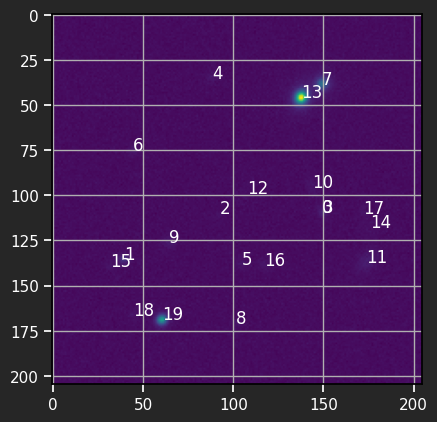

In [ ]:
# print("input_image")
band_num = 2
field_example_to_display = 0
plt.imshow(blend["blend_images"][field_example_to_display, band_num])
for i in range(len(blend["blend_list"][field_example_to_display])):
    plt.text(
        blend["blend_list"][field_example_to_display]["x_peak"][i],
        blend["blend_list"][field_example_to_display]["y_peak"][i],
        str(i),
    )

input_image


/tmp/ipykernel_2841/1560962103.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  bar = fig.colorbar(im1, ax=ax)


<Figure size 1000x1000 with 0 Axes>

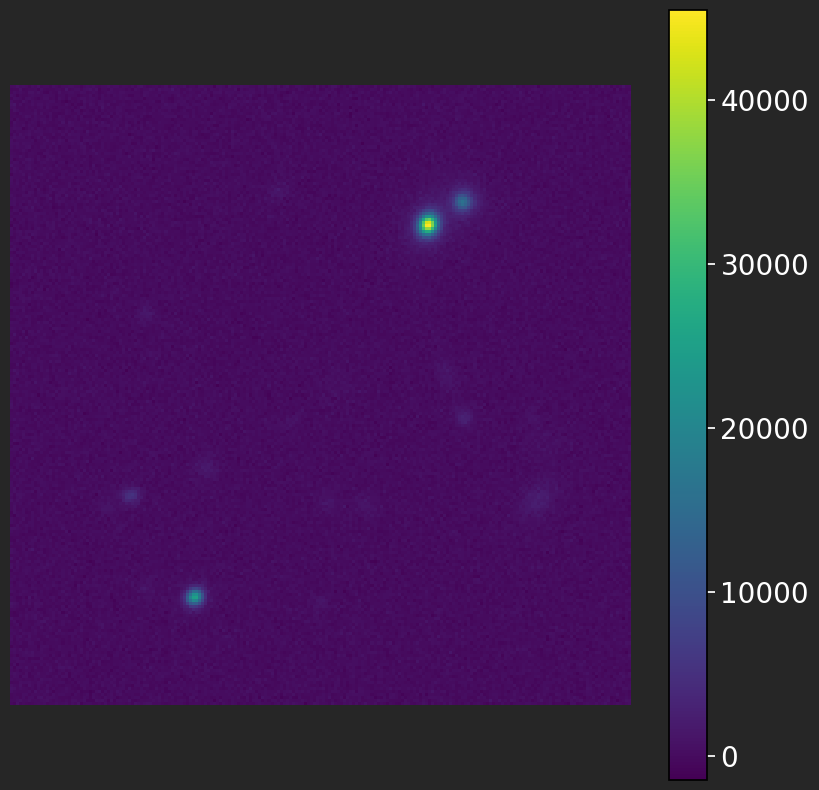

In [ ]:
fig = plt.figure(figsize=(10, 10))
print("input_image")
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
im1 = ax.imshow(blend["blend_images"][field_example_to_display, 2])
# for i in range(len(blend['blend_list'][0])):
#    plt.scatter(blend['blend_list'][0]['x_peak'][i],
#                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
# plt.text(blend['blend_list'][0]['x_peak'][i]-1, blend['blend_list'][0]['y_peak'][i]-1, str(i), c='black', fontsize=15)
bar = fig.colorbar(im1, ax=ax)
bar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("input field")

# Initialize the Deblender

In [ ]:
tf.get_logger().setLevel("ERROR")

latent_dim = 16
kl_weight = 1

weights_path = os.path.join(get_data_dir_path(), "LSST")
deb = Deblend(latent_dim=16, weights_path=weights_path)

field = blend["blend_images"]

# Run MADNESS

In [ ]:
convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(
    rtol=0.05,
    min_num_steps=40,
    window_size=15,
)

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.075,
    decay_steps=30,
    decay_rate=0.8,
    staircase=True,
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
# optimizer=tfa.optimizers.AdaBelief(learning_rate=lr_scheduler)

detected_positions = np.zeros((len(blend["blend_list"]), max_number, 2))
num_components = []
for field_num in range(len(blend["blend_list"])):
    for gal_num in range(len(blend["blend_list"][field_num])):
        detected_positions[field_num][gal_num][0] = blend["blend_list"][field_num][
            "y_peak"
        ][gal_num]
        detected_positions[field_num][gal_num][1] = blend["blend_list"][field_num][
            "x_peak"
        ][gal_num]
    num_components.append(len(blend["blend_list"][field_num]))

deb(
    blended_fields=blend["blend_images"],
    detected_positions=detected_positions,
    num_components=num_components,
    use_log_prob=True,
    linear_norm_coeff=linear_norm_coeff,
    max_iter=200,
    convergence_criterion=convergence_criterion,
    optimizer=optimizer,
    use_debvader=True,
)

use debvader: True

Using encoder for initial point
Time taken for initialization: 0.4668905735015869

--- Starting gradient descent in the latent space ---
Maximum number of iterations: 200
Number of fields: 4
Number of Galaxies: [20 14 12 16]
Dimensions of latent space: 16
--- Gradient descent complete ---
Time taken for gradient descent: 112.82935738563538


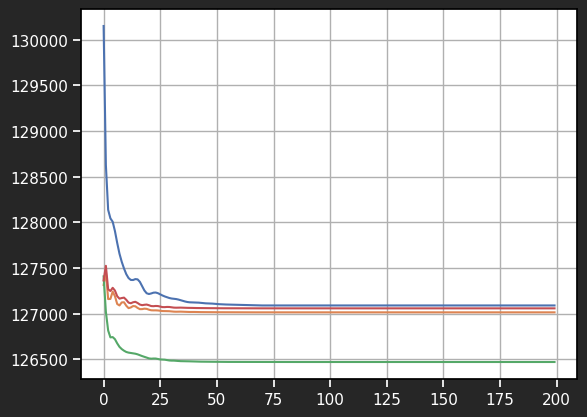

In [ ]:
plt.plot(deb.results);

/tmp/ipykernel_2841/1873853572.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im1, ax=ax[i, 0])
/tmp/ipykernel_2841/1873853572.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im1, ax=ax[i, 1])
/tmp/ipykernel_2841/1873853572.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im2, ax=ax[i, 2])
/tmp/ipykernel_2841/1873853572.py:48: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


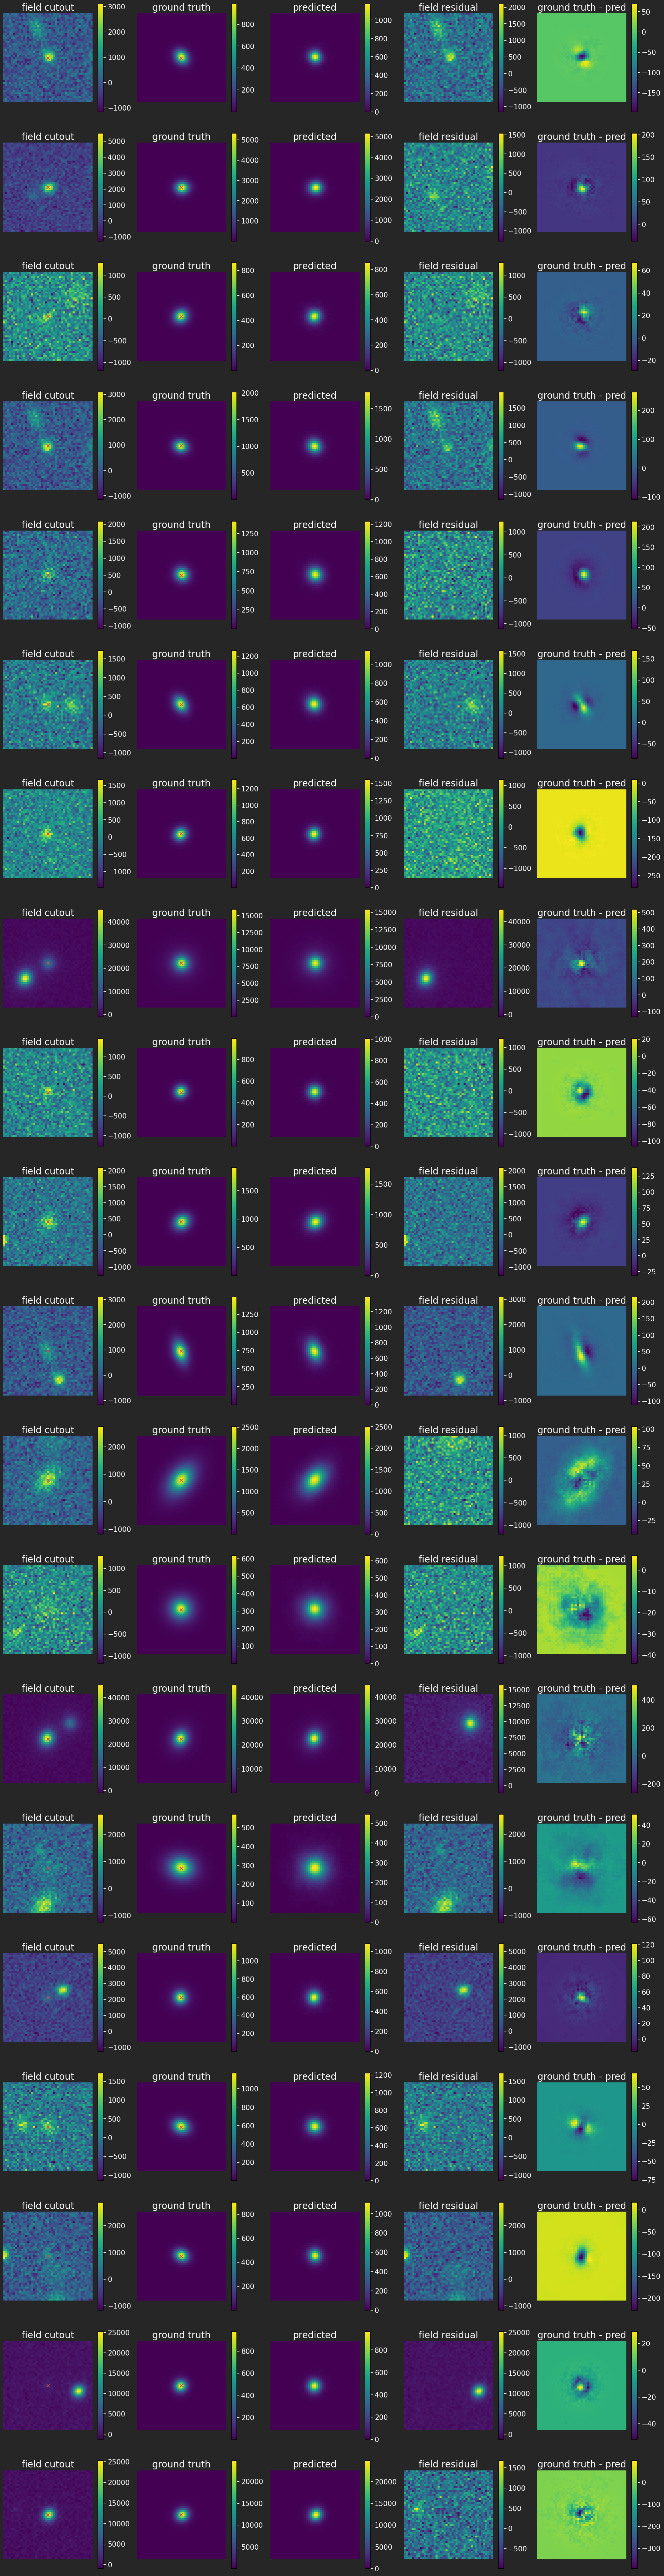

In [ ]:
fig, ax = plt.subplots(
    len(blend["blend_list"][field_example_to_display]),
    5,
    figsize=(5 * 5, 5 * len(blend["blend_list"][0])),
)

for i in range(len(blend["blend_list"][field_example_to_display])):

    # print("image number: " + str(i))
    # image_index = shuffled_indices[i]
    field_cutout_r_band = extract_cutouts(
        blend["blend_images"][field_example_to_display],
        [detected_positions[field_example_to_display][i]],
        distances_to_center=False,
        channel_last=False,
        cutout_size=45,
    )[0][0, :, :, 2]
    galaxy_cutout_r_band = extract_cutouts(
        blend["isolated_images"][field_example_to_display][i],
        [detected_positions[field_example_to_display][i]],
        distances_to_center=False,
        cutout_size=45,
    )[0][0, :, :, 2]

    im1 = ax[i, 0].imshow(field_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 0].set_title("field cutout", fontsize=20)
    ax[i, 0].scatter(22, 22, c="r", marker="x")
    ax[i, 0].axis("off")

    im1 = ax[i, 1].imshow(galaxy_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 1].set_title("ground truth", fontsize=20)
    ax[i, 1].scatter(22, 22, c="r", marker="x")
    ax[i, 1].axis("off")

    im2 = ax[i, 2].imshow(deb.components[field_example_to_display][i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 2])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 2].set_title("predicted", fontsize=20)
    ax[i, 2].axis("off")

    im3 = ax[i, 3].imshow(
        field_cutout_r_band - deb.components[field_example_to_display][i][:, :, 2]
    )
    cbar = fig.colorbar(im3, ax=ax[i, 3])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 3].set_title("field residual", fontsize=20)
    ax[i, 3].axis("off")

    im3 = ax[i, 4].imshow(
        galaxy_cutout_r_band - deb.components[field_example_to_display][i][:, :, 2]
    )
    cbar = fig.colorbar(im3, ax=ax[i, 4])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 4].set_title("ground truth - pred", fontsize=20)
    ax[i, 4].axis("off")

plt.savefig("MAP_predictions")
plt.show()

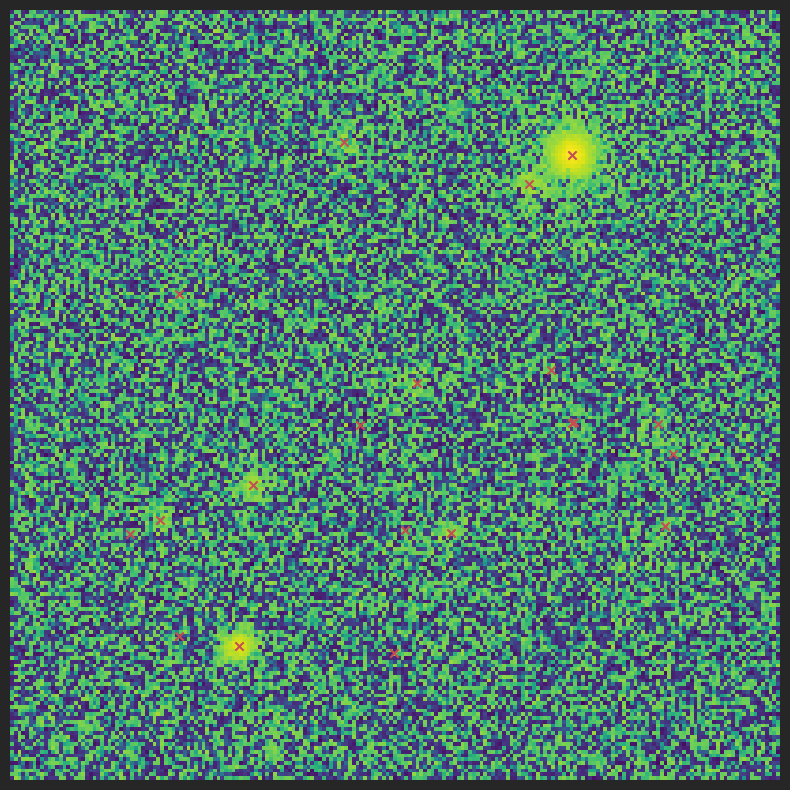

In [ ]:
# This is just to make the blends more visible

sns.set_theme(
    style={
        "axes.grid": False,
        "axes.labelcolor": "white",
        "figure.facecolor": ".15",
        "xtick.color": "white",
        "ytick.color": "white",
        "text.color": "white",
        "image.cmap": "viridis",
    }
)

fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.arcsinh(blend["blend_images"][field_example_to_display][0]))
for i in range(len(blend["blend_list"][field_example_to_display])):
    plt.scatter(
        blend["blend_list"][field_example_to_display]["x_peak"][i],
        blend["blend_list"][field_example_to_display]["y_peak"][i],
        marker="x",
        c="r",
    )

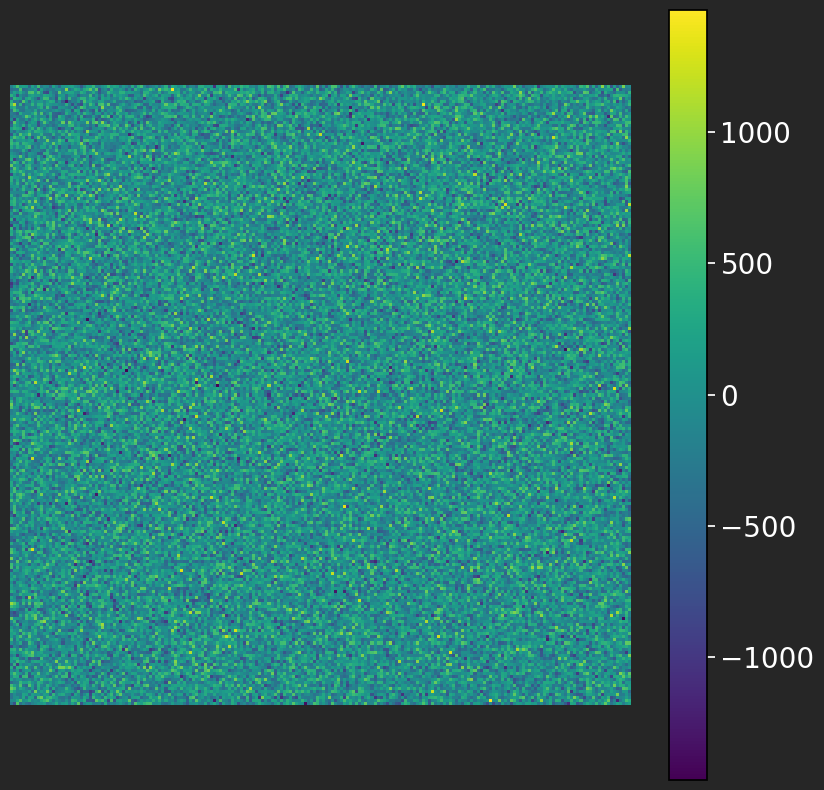

In [ ]:
# Residual after MADNESS run
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
tf.config.run_functions_eagerly(True)

padding_infos = deb.get_padding_infos()
index_pos_to_sub = deb.get_index_pos_to_sub()
residual = compute_residual(
    blended_field=np.transpose(
        blend["blend_images"][field_example_to_display], axes=[1, 2, 0]
    ),
    reconstructions=deb.components[field_example_to_display],
    index_pos_to_sub=index_pos_to_sub[field_example_to_display],
    num_components=num_components[field_example_to_display],
).numpy()
# residual = np.transpose(deb.postage_stamp,
im1 = ax.imshow(residual[:, :, 2])
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("residual")

# for i in range(len(blend['blend_list'][0])):
# plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

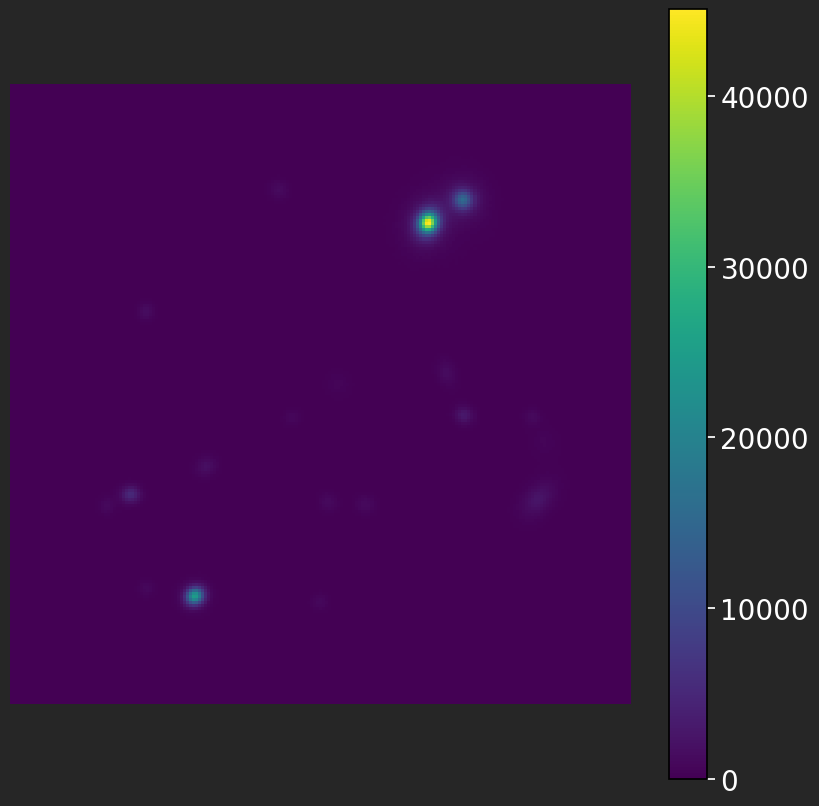

In [ ]:
sns.set_theme(
    style={
        "axes.grid": False,
        "axes.labelcolor": "white",
        "figure.facecolor": ".15",
        "xtick.color": "white",
        "ytick.color": "white",
        "text.color": "white",
        "image.cmap": "viridis",
    }
)
predicted_field = blend["blend_images"][field_example_to_display] - np.transpose(
    residual, axes=[2, 0, 1]
)
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
im1 = ax.imshow(predicted_field[2, :, :])
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.show();